 # Try shooting method again

In [201]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

 Labor market tradeoff function

In [202]:
# Define g(x) and g'(x) (labor market equilibrium tradeoff) function

def g(x):
    y = 1.25 - (x*(1.25**0.5 - 0.5) + 0.5)**2
    
    return y

def g_prime(x):
    y = - 2*(x*(1.25**0.5 - 0.5) + 0.5)*(1.25**0.5 - 0.5)
    
    return y


# Define g(x) and g'(x) (labor market equilibrium tradeoff) function

def g(x):
    y = 1-x

    return y

def g_prime(x):
    return -1

In [203]:
# Evaluate derivative at corners
g_prime_0 = g_prime(0)
g_prime_1 = g_prime(1)

 Set parameters

In [204]:
# Parameters
rho = 0.03
r = 0.05
a = 1
delta = 0.01
c_param = 0.3
l_param = 0.3
B_param = 0.3
params = (rho, r, a, delta, c_param, l_param, B_param)

T = 70

 Utility functions and derivatives

In [205]:
# Define utility functions
def U(c, c_param):
    u = (c**c_param)/c_param
    return u

def U_prime(c, c_param):
    u_prime = c**(c_param - 1)
    return u_prime

def L(l, l_param):
    u = (l**l_param)/l_param
    return u

def L_prime(l, l_param):
    u_prime = l**(l_param - 1)
    return u_prime

def B(A, B_param):
    u = 10*(A**B_param)/B_param
    return u

def B_prime(A, B_param):
    if A <= 0:
        return 1e99

    u_prime = 10*A**(B_param - 1)
    return u_prime

 Define a function that produces K1, A1, mu1, p1, c, l, and x, given initial values K0, A0, mu0, p0

In [206]:
def simulate(K0, A0, mu0, p0, params):
    rho, r, a, delta, c_param, l_param, B_param = params

    # rho and r pins down evolution of mu
    mu1 = mu0*(rho - r) + mu0

    # Value of mu pins down value of c
    c = mu0**(1/(c_param-1))

    # Check for retirement
    def mc_leisure(x, K0, mu0, p0):
        return - mu0*K0*g(x) - a*p0*K0*x

    max_mc_leisure = - opt.minimize(mc_leisure, 0.5, bounds = ((0, 1),), args = (K0, mu0, p0)).fun # Retire if MU of leisure at retirement is greater than maximal MB of work

    if max_mc_leisure < 1:
        retirement = True
    else:
        retirement = False

    if retirement == True:
        l = 1
        x = -0.2
    else:
        # If non-retired, then need to compute value of x and l
        # Check corners
        # x = 0 corner (no investment in human capital)
        if a*p0 + mu0*g_prime_0 < 0:
            no_learning = True
        else:
            no_learning = False

        # x = 1 corner (in school)
        if a*p0 + mu0*g_prime_1 > 0:
            in_school = True
        else:
            in_school = False

        # Evaluate at interior if not at corner; otherwise use corner values
        if no_learning == False and in_school == False:
            interior_x = True
        else:
            interior_x = False

        # Compute value of l if x is at corner
        if interior_x == False:
            if in_school == True: # in school means x = 1
                l = (a*p0*K0)**(1/(l_param-1))
                x = 1
            
            if no_learning == True: # no learning means x = 0
                l = (mu0*K0)**(1/(l_param-1))
                x = 0
        else:
            # If l and x are interior, the values of p and mu pins down x, which then determines l
            x = ((a*p0/mu0)/(2*(1.25**0.5 - 0.5)) - 0.5)/(1.25**0.5 - 0.5)
            l = (mu0*K0*g(x) + a*p0*K0*x)**(1/(l_param-1))
            

    # Evolution of p, K, and A
    h = 1 - l
    if retirement == True: # If l = 1 (retired), x and l does not matter
        p1 = p0*(rho + delta) + p0
        A1 = r*A0 - c + A0
        K1 = -delta*K0 + K0
    else:
        p1 = p0*(rho + delta - a*x*h) - g(x)*h*mu0 + p0
        A1 = r*A0 + g(x)*h*K0 - c + A0
        K1 = (a*x*h - delta)*K0 + K0
        

    return K1, A1, mu1, p1, c, l, x

Define a function that simulates path of all variables

In [207]:
def simulate_path(initial_costate, initial_state, params):

    K_path = np.zeros(T+1)
    A_path = np.zeros(T+1)
    mu_path = np.zeros(T+1)
    p_path = np.zeros(T+1)
    c_path = np.zeros(T)
    l_path = np.zeros(T)
    x_path = np.zeros(T)

    # Initial conditions
    # Initial state
    K_path[0] = initial_state[0]
    A_path[0] = initial_state[1]

    # Initial costate
    mu_path[0] = initial_costate[0]
    p_path[0] = initial_costate[1]

    # Iterate forward in time
    for t in range(T):
        K0 = K_path[t]
        A0 = A_path[t]
        mu0 = mu_path[t]
        p0 = p_path[t]

        K1, A1, mu1, p1, c, l, x = simulate(K0, A0, mu0, p0, params)

        K_path[t+1] = K1
        A_path[t+1] = A1
        mu_path[t+1] = mu1
        p_path[t+1] = p1
        c_path[t] = c
        l_path[t] = l
        x_path[t] = x

    return K_path, A_path, mu_path, p_path, c_path, l_path, x_path

Define a function that returns terminal conditions given initial states and costates

In [208]:
def terminal_conditions(initial_costate, initial_state, params):
    (rho, r, a, delta, c_param, l_param, B_param) = params

    # Run simulation and compute terminal conditions
    K_path, A_path, mu_path, p_path, c_path, l_path, x_path = simulate_path(initial_costate, initial_state, params)

    # Evaluate terminal conditions
    # Terminal states
    AT = A_path[T-1]
    KT = K_path[T-1]
    muT = mu_path[T-1]
    pT = p_path[T-1]
    cT = c_path[T-1]

    # Bequest from FOC
    bequest = (muT)**(1/(B_param - 1))

    # Bequest constraint
    bequest_err = (AT - cT) - bequest

    # Terminal conditions
    return np.abs(100*bequest_err) + np.abs(pT)

In [209]:
initial_state = [1, 1]
solution = opt.differential_evolution(terminal_conditions, bounds = [(0, 100), (0, 100)], args = (initial_state, params,), )

In [210]:
solution

     fun: 152.78890228000023
 message: 'Optimization terminated successfully.'
    nfev: 1389
     nit: 45
 success: True
       x: array([ 1.1622413 , 27.29752645])

In [211]:
costate_solution = solution.x

In [212]:
K_path, A_path, mu_path, p_path, c_path, l_path, x_path = simulate_path(costate_solution, initial_state, params)

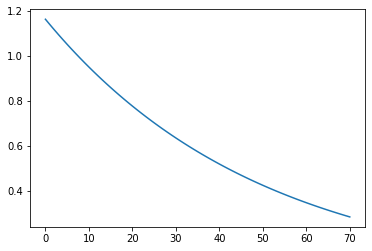

In [213]:
plt.plot(mu_path)

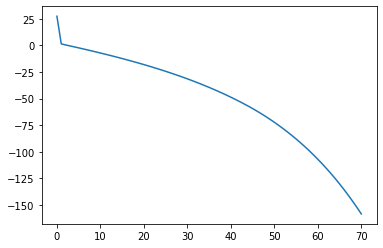

In [214]:
plt.plot(p_path)

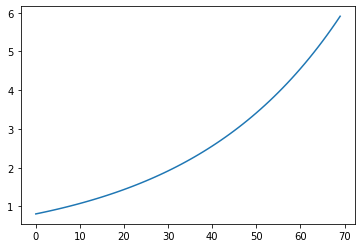

In [215]:
plt.plot(c_path)

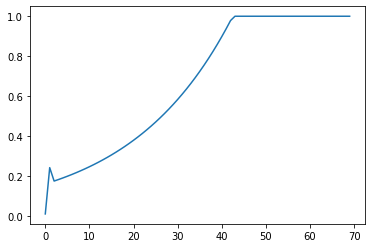

In [216]:
plt.plot(l_path)

In [217]:
l_path

array([0.00887964, 0.24084546, 0.17368222, 0.18135309, 0.18936276,
       0.19772619, 0.206459  , 0.2155775 , 0.22509873, 0.23504047,
       0.24542131, 0.25626062, 0.26757867, 0.27939659, 0.29173647,
       0.30462135, 0.3180753 , 0.33212347, 0.34679208, 0.36210856,
       0.3781015 , 0.39480079, 0.41223763, 0.43044458, 0.44945567,
       0.4693064 , 0.49003386, 0.51167677, 0.53427557, 0.55787247,
       0.58251155, 0.60823885, 0.63510242, 0.66315246, 0.69244136,
       0.72302383, 0.75495702, 0.78830057, 0.82311678, 0.85947068,
       0.8974302 , 0.93706625, 0.97845287, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

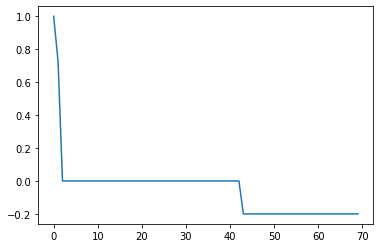

In [218]:
plt.plot(x_path)

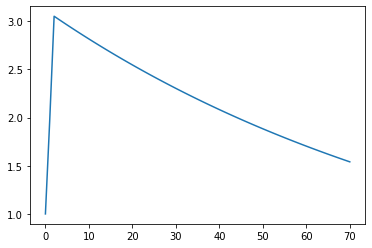

In [219]:
plt.plot(K_path)

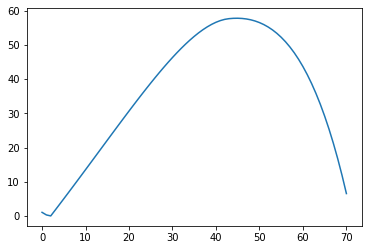

In [220]:
plt.plot(A_path)

In [221]:
mu_grid = np.linspace(1, 3, 50)
p_grid = np.linspace(1, 3, 50)
pT_grid = np.zeros((50, 50))
bequest_grid = np.zeros((50, 50))
initial_state = [1, 1]

for i, mu in enumerate(mu_grid):
    for j, p in enumerate(p_grid):
        K_path, A_path, mu_path, p_path, c_path, l_path, x_path = simulate_path([mu, p], initial_state, params)

        # Evaluate terminal conditions
        # Terminal states
        AT = A_path[T-1]
        KT = K_path[T-1]
        muT = mu_path[T-1]
        pT = p_path[T-1]
        cT = c_path[T-1]

        # Bequest from FOC
        bequest = (muT)**(1/(B_param - 1))

        # Bequest constraint
        bequest_err = AT - bequest

        bequest_grid[i, j] = bequest_err
        pT_grid[i, j] = pT



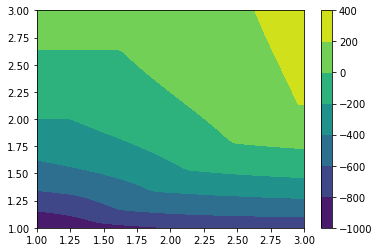

In [222]:
plt.contourf(mu_grid, p_grid, bequest_grid, cmap='viridis')
plt.colorbar();

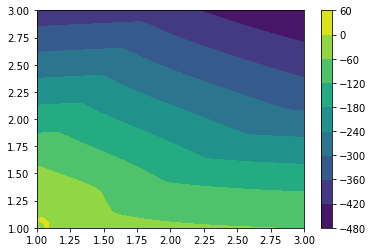

In [223]:
plt.contourf(mu_grid, p_grid, pT_grid, cmap='viridis')
plt.colorbar();

In [224]:
(np.abs(bequest_grid)).min()

0.06674493564890405

In [225]:
(np.abs(bequest_grid) + np.abs(pT_grid)).min()

215.68639802417175